<h1><h1>Surface Cracks Detection with PyTorch </h1>

<h2 id="auxiliary">Imports and Auxiliary Functions</h2>

In [1]:
import torchvision.models as models
from PIL import Image
import pandas
from torchvision import transforms
import torch.nn as nn
import time
import torch 
import matplotlib.pylab as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader
import h5py
import os
import glob
torch.manual_seed(0)

In [2]:
from matplotlib.pyplot import imshow
import matplotlib.pylab as plt
from PIL import Image
import pandas as pd
import os

<h2 id="data_class_with_images">Creating Dataset Class</h2>

In [3]:
class Dataset(Dataset):

    # Constructor
    def __init__(self,transform=None,train=True):
        directory="C:\\Users\\piter.PC_PIOTREK\\Desktop\\IBM_Certificate\\AI_Capstone_Project_Images"
        positive="Positive"
        negative="Negative"

        positive_file_path=os.path.join(directory,positive)
        negative_file_path=os.path.join(directory,negative)
        positive_files=[os.path.join(positive_file_path,file) for file in  os.listdir(positive_file_path) if file.endswith(".jpg")]
        positive_files.sort()
        negative_files=[os.path.join(negative_file_path,file) for file in  os.listdir(negative_file_path) if file.endswith(".jpg")]
        negative_files.sort()
        number_of_samples=len(positive_files)+len(negative_files)
        self.all_files=[None]*number_of_samples
        self.all_files[::2]=positive_files
        self.all_files[1::2]=negative_files 
        # The transform is goint to be used on image
        self.transform = transform
        #torch.LongTensor
        self.Y=torch.zeros([number_of_samples]).type(torch.LongTensor)
        self.Y[::2]=1
        self.Y[1::2]=0
        
        if train:
            self.all_files=self.all_files[0:30000] #Change to 30000 to use the full test dataset
            self.Y=self.Y[0:30000] #Change to 30000 to use the full test dataset
            self.len=len(self.all_files)
        else:
            self.all_files=self.all_files[30000:]
            self.Y=self.Y[30000:]
            self.len=len(self.all_files)    
       
    # Get the length
    def __len__(self):
        return self.len
    
    # Getter
    def __getitem__(self, idx):
         
        image=Image.open(self.all_files[idx])
        y=self.Y[idx]     
        
        # If there is any transform method, apply it onto the image
        if self.transform:
            image = self.transform(image)

        return image, y

In [4]:
dataset_train=Dataset(train=True)
dataset_val=Dataset(train=False)

In [5]:
dataset_train[0][0].size

(227, 227)

<h2 id="data_example">Data Visualization</h2>

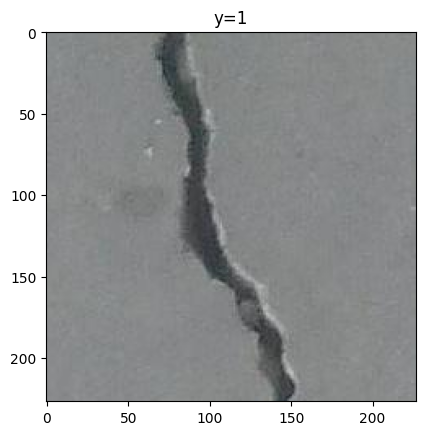

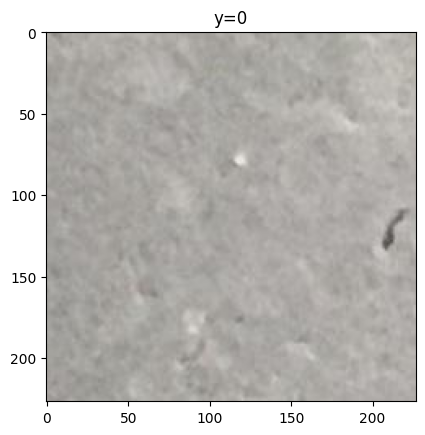

In [6]:
for i in range(2):
    plt.imshow(dataset_train[i][0])
    plt.title("y="+str(dataset_train[i][1].item()))
    plt.show()

<h2 id="trasform_Data_object">Dataset Object and Transformation</h2>

In [7]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

transform =transforms.Compose([transforms.Resize((224,224)),
                               transforms.RandomHorizontalFlip(),
                               transforms.ToTensor(), 
                               transforms.Normalize(mean, std)])

dataset_train=Dataset_Images(transform=transform,train=True)
dataset_val=Dataset_Images(transform=transform,train=False)

In [8]:
dataset_train=Dataset(transform=transform,train=True)
dataset_val=Dataset(transform=transform,train=False)

In [9]:
dataset_train[0][0].shape

torch.Size([3, 224, 224])

In [10]:
size_of_image=3*224*224
size_of_image

150528

In [11]:
train_loader = torch.utils.data.DataLoader(dataset=dataset_train, batch_size=100)
validation_loader = torch.utils.data.DataLoader(dataset=dataset_val, batch_size=100)

In [12]:
n_epochs = 10
input_dim = 224*224*3
output_dim = 2

<h2 id="Softmax_model">Simple Softmax Model</h2>

In [18]:
class SoftMax(nn.Module):
    def __init__(self, in_size, out_size):
        super(SoftMax, self).__init__()
        self.linear = nn.Linear(in_size, out_size)
        
    def forward(self,x):
        out = self.linear(x)
        return out

In [19]:
model_Softmax = SoftMax(input_dim, output_dim)

In [48]:
learning_rate = 0.005
optimizer = torch.optim.Adam(model_Softmax.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()
n_epochs = 5

In [16]:
n_epochs = 5
loss_list = []
accuracy_list = []
N_test = len(dataset_val)

def train_model(n_epochs):
    for epoch in range(n_epochs):
        for x, y in train_loader:
            optimizer.zero_grad()
            z = model_Softmax(x.view(-1, input_dim))
            loss = criterion(z, y)
            loss.backward()
            optimizer.step()
            
        correct = 0
        # perform a prediction on the validationdata  
        for x_test, y_test in validation_loader:
            z = model_Softmax(x_test.view(-1, input_dim))
            _, yhat = torch.max(z.data, 1)
            correct += (yhat == y_test).sum().item()
        accuracy = correct / N_test
        loss_list.append(loss.data)
        accuracy_list.append(accuracy)
        print("Accuracy after epoch {} - {}".format(epoch+1, accuracy))
        
train_model(n_epochs)

Accuracy after epoch 1 - 0.6966
Accuracy after epoch 2 - 0.8336
Accuracy after epoch 3 - 0.8378
Accuracy after epoch 4 - 0.7468
Accuracy after epoch 5 - 0.7436


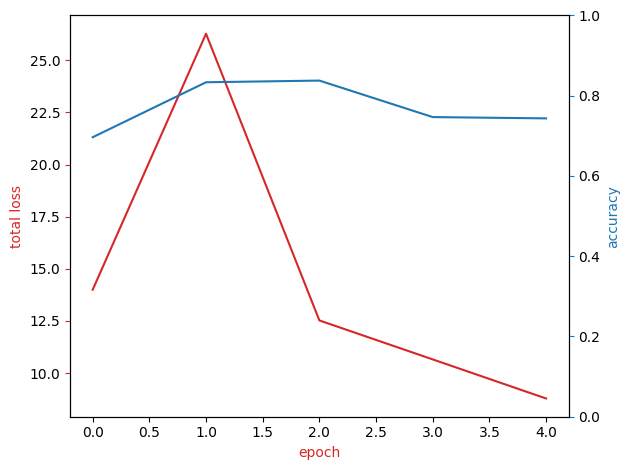

In [17]:
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.plot(loss_list,color=color)
ax1.set_xlabel('epoch',color=color)
ax1.set_ylabel('total loss',color=color)
ax1.tick_params(axis='y', color=color)
    
ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('accuracy', color=color)  
ax2.plot( accuracy_list, color=color)
ax2.tick_params(axis='y', color=color)
ax2.set_ylim([0, 1])
fig.tight_layout()

<h1><h1>Resnet18 </h1>

<h2 id="resnet18_model">Implementing Resnet18 model using CPU computation</h2>

In [18]:
model = models.resnet18(pretrained=True)

C:\Users\piter.PC_PIOTREK\Desktop\IBM_Certificate\IBM_venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\piter.PC_PIOTREK\Desktop\IBM_Certificate\IBM_venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [19]:
for param in model.parameters():
    param.requires_grad=False

In [20]:
model.fc=nn.Linear(512,2)

In [21]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam([parameters  for parameters in model.parameters() if parameters.requires_grad],lr=learning_rate)

In [22]:
loss_list=[]
accuracy_list=[]
correct=0
Loss=0
N_test=len(dataset_val)
N_train=len(dataset_train)

start_time = time.time()

for epoch in range(n_epochs):
    for x, y in train_loader:
        model.train() 
        #clear gradient 
        optimizer.zero_grad()
        #make a prediction 
        z=model(x)
        # calculate loss 
        loss=criterion(z,y)
        # calculate gradients of parameters 
        loss.backward()
        # update parameters 
        optimizer.step()
    correct=0
    for x_test, y_test in validation_loader:
        # set model to eval 
        model.eval()
        #make a prediction 
        z=model(x_test)
        #find max 
        _, yhat = torch.max(z.data, 1)
        #Calculate misclassified  samples in mini-batch 
        correct += (yhat == y_test).sum().item()
   
    accuracy=correct/N_test
    accuracy_list.append(accuracy)
    loss_list.append(loss.data.to('cpu'))

end_time = time.time()

In [23]:
print("Total computation time for training on CPU AMD Ryzen 5 7600 - 6 cores 12 threads:")
print("{:.2f} minutes".format((end_time - start_time)/60))

Total computation time for training on CPU AMD Ryzen 5 7600 - 6 cores 12 threads:
40.64 minutes


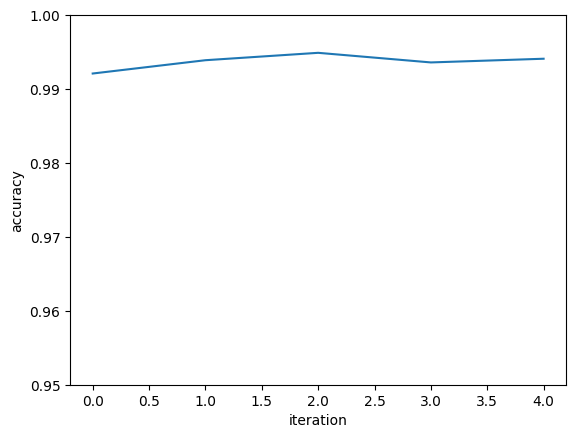

In [32]:
plt.plot(accuracy_list)
plt.xlabel("iteration")
plt.ylabel("accuracy")
plt.ylim(0.95,1)
plt.show()

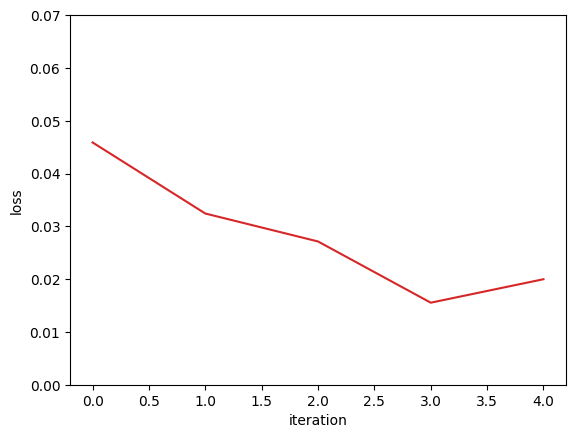

In [28]:
plt.plot(loss_list, color='tab:red')
plt.xlabel("iteration")
plt.ylabel("loss")
plt.ylim(0,0.07)
plt.show()

<h2 id="resnet18_model_on_cuda">Implementing Resnet18 model using CUDA computation</h2>

In [49]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda

NVIDIA GeForce GTX 1080
Memory Usage:
Allocated: 0.2 GB
Cached:    1.0 GB


In [50]:
model = models.resnet18(pretrained=True)

In [51]:
for param in model.parameters():
    param.requires_grad=False

In [52]:
model.fc=nn.Linear(512,2)
model = model.to(device)

In [53]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam([parameters for parameters in model.parameters() if parameters.requires_grad],lr=learning_rate)

In [54]:
loss_list=[]
accuracy_list=[]
correct=0
Loss=0
N_test=len(dataset_val)
N_train=len(dataset_train)

start_time = time.time()
for epoch in range(n_epochs):
    for x, y in train_loader:
        x = x.to(device)
        y = y.to(device)
        model.train() 
        #clear gradient 
        optimizer.zero_grad()
        #make a prediction 
        z=model(x)
        # calculate loss 
        loss=criterion(z,y)
        # calculate gradients of parameters 
        loss.backward()
        # update parameters 
        optimizer.step()
    correct=0
    for x_test, y_test in validation_loader:
        x_test = x_test.to(device)
        y_test = y_test.to(device)
        # set model to eval 
        model.eval()
        #make a prediction 
        z=model(x_test)
        #find max 
        _, yhat = torch.max(z.data, 1)
        #Calculate misclassified  samples in mini-batch 
        correct += (yhat == y_test).sum().item()
        
   
    accuracy=correct/N_test
    accuracy_list.append(accuracy)
    loss_list.append(loss.data.to('cpu'))

end_time = time.time()

In [55]:
print("Total computation time for training on GPU NVIDIA GTX1080 - 2560 CUDA cores:")
print("{:.2f} minutes".format((end_time - start_time)/60))

Total computation time for training on GPU NVIDIA GTX1080 - 2560 CUDA cores:
4.12 minutes


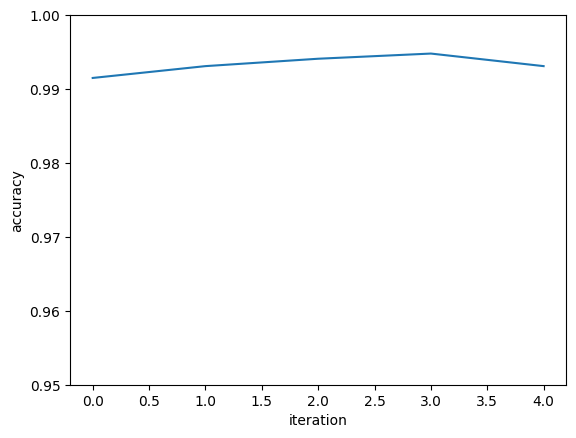

In [56]:
plt.plot(accuracy_list)
plt.xlabel("iteration")
plt.ylabel("accuracy")
plt.ylim(0.95,1)
plt.show()

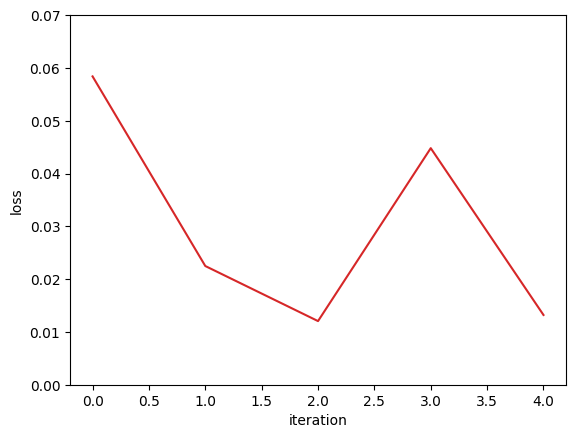

In [57]:
plt.plot(loss_list, color='tab:red')
plt.xlabel("iteration")
plt.ylabel("loss")
plt.ylim(0,0.07)
plt.show()

<h2>Results</h2>

There is a big difference in computation time between CPU and GPU.
Time required to train Resnet18 network on a 40000 samples dataset with 5 epochs was:
- CPU - 40.64 minutes
- GPU - 4.12 minutes

The 8th years old graphic card was 10 times faster that much more recent CPU